# Filtering Vector Attributes

In [ ]:
# !pip install ipyplot

In [1]:
PROJECT_ID = 'hybrid-vertex'  # <--- TODO: CHANGE THIS
LOCATION = 'us-central1' 
!gcloud config set project {PROJECT_ID}

Updated property [core/project].


In [216]:
from google.cloud import aiplatform as vertex_ai
from google.cloud import storage

from pprint import pprint

storage_client = storage.Client(project=PROJECT_ID)

vertex_ai.init(project=PROJECT_ID,location=LOCATION)

## pre-trained model

In [20]:
import os 

os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
TF_HUB_MODEL_DIR = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

In [21]:
import tensorflow as tf

def read_and_decode(filename, reshape_dims=[IMG_HEIGHT, IMG_WIDTH]):
    # Read the file
    img = tf.io.read_file(filename)
  
    # Convert the compressed string to a 3D uint8 tensor.
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)

    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    # This makes the img 1 x 224 x 224 x 3 tensor with the data type of float32
    img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

    # Resize the image to the desired size.
    return tf.image.resize(img, reshape_dims)

In [278]:
FILE_NAME = f'{DEST_FOLDER}/train/train/097924837X.jpg'
# TEST_IMG_PATH = f'gs://{BUCKET}/{FILE_NAME}'
# array = read_and_decode(TEST_IMG_PATH)
# array.numpy()

In [22]:
import tensorflow_hub as hub

layers = [
      hub.KerasLayer(
          f"{TF_HUB_MODEL_DIR}",
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Flatten()
]
model = tf.keras.Sequential(
    layers, name='visual_embedding'
)
print(model.summary())

Model: "visual_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________
None


### local testing

In [312]:
BUCKET = 'retail-products-kaggle'
DEST_FOLDER = 'dataset'
CSV_URI = f'gs://{BUCKET}/{DEST_FOLDER}/train.csv'

In [313]:
train_csv = pd.read_csv(CSV_URI)
train_csv['categories'].value_counts()

Arts, Crafts & Sewing        2225
Beauty                       2202
Grocery & Gourmet Food       2201
Sports & Outdoors            2201
Automotive                   2200
Industrial & Scientific      2200
Musical Instruments          2200
Appliances                   2200
Office Products              2200
All Beauty                   2200
Toys & Games                 2200
Electronics                  2200
All Electronics              2200
Cell Phones & Accessories    2200
Patio, Lawn & Garden         2200
Baby                         2200
Baby Products                2200
Health & Personal Care       2200
Tools & Home Improvement     2200
Clothing, Shoes & Jewelry    2200
Pet Supplies                 2200
Name: categories, dtype: int64

In [314]:
DEST_FOLDER = 'data-full'
CSV_URI = f'gs://{BUCKET}/{DEST_FOLDER}/train.csv'

In [315]:
train_csv = pd.read_csv(CSV_URI)
train_csv['categories'].value_counts()

Arts, Crafts & Sewing        2225
Beauty                       2202
Grocery & Gourmet Food       2201
Sports & Outdoors            2201
Automotive                   2200
Industrial & Scientific      2200
Musical Instruments          2200
Appliances                   2200
Office Products              2200
All Beauty                   2200
Toys & Games                 2200
Electronics                  2200
All Electronics              2200
Cell Phones & Accessories    2200
Patio, Lawn & Garden         2200
Baby                         2200
Baby Products                2200
Health & Personal Care       2200
Tools & Home Improvement     2200
Clothing, Shoes & Jewelry    2200
Pet Supplies                 2200
Name: categories, dtype: int64

## Data

In [3]:
BUCKET = 'retail-products-kaggle'
ZIP_PATH = 'retail-products-classification.zip' # if the file is gs://$BUCKET/retail-products-classification.zip
DEST_FOLDER = 'data-full' # folder to place unzipped files

CSV_URI = f'gs://{BUCKET}/{DEST_FOLDER}/train.csv'

In [4]:
IMAGE_DIR = f'gs://{BUCKET}'
!gsutil ls $IMAGE_DIR

gs://retail-products-kaggle/retail-products-classification.zip
gs://retail-products-kaggle/data-full/
gs://retail-products-kaggle/dataset/
gs://retail-products-kaggle/indexes/
gs://retail-products-kaggle/pipeline_root/
gs://retail-products-kaggle/saved-models/


### product categories

In [27]:
import pandas as pd

train_csv = pd.read_csv(CSV_URI)
train_csv.head(1)

,ImgId,title,description,categories
0,B000HYL1V6,TUNGSTEN SOLDER PICK WITH HANDLE,Solder Pick for picking up molten solder when ...,"Arts, Crafts & Sewing"


In [7]:
#### Test 

IMAGE_ID = '097585562X'

cat = train_csv.loc[train_csv['ImgId'] == IMAGE_ID, 'categories'].item()
cat

'Toys & Games'

## Create embeddings dataset

In [39]:
IMG_PATH = f'gs://{BUCKET}/{DEST_FOLDER}/train/train'

LIST_DIR = tf.io.gfile.listdir(IMG_PATH)
len(LIST_DIR)

42000

In [235]:
import os.path
import time

def create_embeddings_dataset(embedder, img_path, num_test_samples):
    
    # dataset_filenames = []
    dataset_embeddings = []
    ids_list = []
    id_cat_list = []
    
    start = time.time()
    
    list_dir = tf.io.gfile.listdir(img_path)
    for file in list_dir[:num_test_samples]:
        img_tensor = read_and_decode(img_path + "/" + file, [IMG_WIDTH, IMG_HEIGHT])
        embeddings = embedder(img_tensor)
        
        IMAGE_ID = file.split(".")[0]
        CAT = train_csv.loc[train_csv['ImgId'] == IMAGE_ID, 'categories'].item()
        
        # dataset_filenames.append(file)
        dataset_embeddings.extend(embeddings)
        ids_list.append(IMAGE_ID)
        id_cat_list.append(CAT)
  
    dataset_embeddings = tf.convert_to_tensor(dataset_embeddings)
    
    end = time.time()
    elapsed_time = round((end - start), 2)
    print(f'Elapsed time writting embeddings: {elapsed_time} seconds\n')
  
    # return dataset_filenames, dataset_embeddings, ids_list, id_cat_list
    return dataset_embeddings, ids_list, id_cat_list

In [191]:
IMG_PATH = f'gs://{BUCKET}/{DEST_FOLDER}/train/train'

# dataset_filenames, dataset_embeddings, dataset_ids, dataset_id_cats = create_embeddings_dataset(
dataset_embeddings, dataset_ids, dataset_id_cats = create_embeddings_dataset(
    lambda x: model.predict(x),
    IMG_PATH,
    200
)

print(f"Shape of embeddings dataset: {dataset_embeddings.shape}\n") # should be (NUM_IMAGES, 1280)

# print(f"dataset_filenames: {dataset_filenames[:3]}\n")
# print(f"dataset_embeddings: {dataset_embeddings[:3]}")
print(f"dataset_ids: {dataset_ids[:3]}\n")
print(f"dataset_id_cats: {dataset_id_cats[:3]}\n")

Elapsed time writting embeddings: 46.89 seconds

Shape of embeddings dataset: (200, 1280)

dataset_ids: ['B00AATJT9Y', 'B00AATKXGM', 'B00ABKJ16S']

dataset_id_cats: ['All Beauty', 'All Beauty', 'All Beauty']



#### test categories

In [58]:
# IMAGE_ID = 'B00CFCKTFM'

# cat = train_csv.loc[train_csv['ImgId'] == IMAGE_ID, 'categories'].item()
# cat

### clean dataset_ids

In [115]:
# dataset_ids[-10:]

In [192]:
print(f"Length of dataset_ids: {len(dataset_ids)}")
print(f"Length of single vector: {len(dataset_ids[0])}")
dataset_ids[0]

Length of dataset_ids: 200
Length of single vector: 10


'B00AATJT9Y'

In [112]:
# cleaned_ids = [x for x in dataset_ids] #clean up the output

# print(f"Length of cleaned_ids: {len(cleaned_ids)}")
# print(f"Length of single vector: {len(cleaned_ids[0])}")
# cleaned_ids[0]

Length of cleaned_ids: 50
Length of single vector: 10


'B00C19IQ40'

In [114]:
# cleaned_ids[-10:]

### clean dataset_id_cats

In [65]:
# dataset_id_cats[0]

'All Beauty'

In [193]:
print(f"Length of dataset_id_cats: {len(dataset_id_cats)}")
print(f"Length of single vector: {len(dataset_id_cats[0])}")
dataset_id_cats[0]

Length of dataset_id_cats: 200
Length of single vector: 10


'All Beauty'

In [118]:
# cleaned_id_cats = [x for x in dataset_id_cats] #clean up the output

# print(f"Length of cleaned_id_cats: {len(cleaned_id_cats)}")
# print(f"Length of single vector: {len(cleaned_id_cats[0])}")
# cleaned_id_cats[0]

Length of cleaned_id_cats: 50
Length of single vector: 10


'All Beauty'

### clean embedding output

In [194]:
dataset_embeddings

<tf.Tensor: shape=(200, 1280), dtype=float32, numpy=
array([[8.2453972e-01, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        4.4985004e-02, 0.0000000e+00],
       [0.0000000e+00, 5.1301839e-03, 2.8957572e-02, ..., 5.8317417e-01,
        2.0297645e-02, 0.0000000e+00],
       [1.2512228e+00, 0.0000000e+00, 1.4427749e-02, ..., 0.0000000e+00,
        1.2256460e+00, 9.1779965e-01],
       ...,
       [6.3323975e-04, 2.4316449e-01, 1.2177556e+00, ..., 1.0945172e-01,
        0.0000000e+00, 4.5936545e-03],
       [2.7857235e-01, 0.0000000e+00, 3.7195131e-01, ..., 8.8811209e-03,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 3.9684296e-02, 5.6512773e-01, ..., 2.7953389e-01,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)>

In [195]:
print(f"Length of embs: {len(dataset_embeddings)}")
print(f"Length of single vector: {len(dataset_embeddings[0])}")
dataset_embeddings[0]

Length of embs: 200
Length of single vector: 1280


<tf.Tensor: shape=(1280,), dtype=float32, numpy=
array([0.8245397, 0.       , 0.       , ..., 0.       , 0.044985 ,
       0.       ], dtype=float32)>

In [196]:
cleaned_embs = [x.numpy() for x in dataset_embeddings] #clean up the output

print(f"Length of cleaned_embs: {len(cleaned_embs)}")
print(f"Length of single vector: {len(cleaned_embs[0])}")
cleaned_embs[0]

Length of cleaned_embs: 200
Length of single vector: 1280


array([0.8245397, 0.       , 0.       , ..., 0.       , 0.044985 ,
       0.       ], dtype=float32)

In [91]:
# vector_list = []
# for q_vector in dataset_embeddings:
#     vector_list.append(q_vector.numpy())
    
# print(f"query_embeddings shape: {dataset_embeddings.shape}")

# vector_list[0]

query_embeddings shape: (50, 1280)


array([0.15452695, 0.38155636, 0.4874365 , ..., 0.00248238, 0.        ,
       0.00475382], dtype=float32)

## Write json index

In [212]:
VERSION='v2'

cleaned_embs = [x.numpy() for x in dataset_embeddings] #clean up the output
cleaned_id_cats = [x for x in dataset_id_cats] #clean up the output
cleaned_ids = [x for x in dataset_ids] #clean up the output

* `f.write('"crowding_tag":' + ('"a"' if i % 2 == 0 else '"b"') + "}")`

In [201]:
with open(f"test.json", "w") as f:
    counter = 0 
    for img_id, vector, img_cat in zip(cleaned_ids, cleaned_embs, cleaned_id_cats):
        f.write('{"id":"' + str(img_id) + '",')
        f.write('"embedding":[' + ",".join(str(x).strip() for x in list(vector)) + '],')
        f.write('"restricts":[{"namespace":"category","allow":["' + str(img_cat) + '"]},') #,
        f.write('{"namespace":"tag_1","allow":['+ ('"even"' if counter % 2 == 0 else '"odd"') + ']}]}\n')
        counter+=1
    f.close()

In [202]:
!wc -l test.json

200 test.json


In [204]:
# !head -2 test.json

In [213]:

FILTER_INDEX_DIR = f'gs://{BUCKET}/indexes/{VERSION}'

# # gcs_dir should only have index file
# ! gsutil rm -rf {FILTER_INDEX_DIR}/*

! gsutil ls {FILTER_INDEX_DIR}

gs://retail-products-kaggle/indexes/v2/200_emb_test_filter.json


In [207]:
INDEX_JSON_FILE = '200_emb_test_filter.json'

INDEX_GCS_URI = f'{FILTER_INDEX_DIR}/{INDEX_JSON_FILE}'

!gsutil cp test.json $INDEX_GCS_URI

Copying file://test.json [Content-Type=application/json]...
/ [1 files][  2.1 MiB/  2.1 MiB]                                                
Operation completed over 1 objects/2.1 MiB.                                      


## Create ME Indexes

### tree-ah index

In [223]:
NUM_VECTORS = 200
DIMENSIONS = 1280
APPROX_NEIGHBS = 100

DISTANCE_MEASURE_TYPE="DOT_PRODUCT_DISTANCE"
LEAF_NODE_EMB_COUNT=500
LEAF_NODE_SEARCH_PERCENT=7

ANN_DESCRIPTION=f"ANN index to test filtering on Kaggle Retail Dataset; visual search demo"
ANN_LABELS={
    "vector_cnt": str(NUM_VECTORS),
    "dims": str(DIMENSIONS),
    "neighbs": str(APPROX_NEIGHBS),
    "leaf_node_cnt": str(LEAF_NODE_EMB_COUNT),
    "leaf_node_serch": str(LEAF_NODE_SEARCH_PERCENT),
}

DISPLAY_NAME_ann = f"{NUM_VECTORS}_{DIMENSIONS}_tree_ah_index"

print(f"DISPLAY_NAME_ann: {DISPLAY_NAME_ann}")
# pprint(f"ANN_LABELS: {ANN_LABELS}")
ANN_LABELS

DISPLAY_NAME_ann: 200_1280_tree_ah_index


{'vector_cnt': '200',
 'dims': '1280',
 'neighbs': '100',
 'leaf_node_cnt': '500',
 'leaf_node_serch': '7'}

In [225]:
FILTER_INDEX_DIR

'gs://retail-products-kaggle/indexes/v2'

In [226]:
start = time.time()

tree_ah_index = vertex_ai.MatchingEngineIndex.create_tree_ah_index(
    display_name=DISPLAY_NAME_ann,
    contents_delta_uri=f'{FILTER_INDEX_DIR}/',
    dimensions=DIMENSIONS,
    approximate_neighbors_count=APPROX_NEIGHBS,
    distance_measure_type=DISTANCE_MEASURE_TYPE,
    leaf_node_embedding_count=LEAF_NODE_EMB_COUNT,
    leaf_nodes_to_search_percent=LEAF_NODE_SEARCH_PERCENT,
    description=ANN_DESCRIPTION,
    labels=ANN_LABELS,
    sync=True,
)

end = time.time()
elapsed_time = round((end - start), 2)
print(f'Elapsed time creating index: {elapsed_time} seconds\n')

ANN_INDEX_RESOURCE_NAME = tree_ah_index.resource_name
print(f'ANN_INDEX_RESOURCE_NAME: {ANN_INDEX_RESOURCE_NAME}')

Creating MatchingEngineIndex


INFO:google.cloud.aiplatform.matching_engine.matching_engine_index:Creating MatchingEngineIndex


Create MatchingEngineIndex backing LRO: projects/934903580331/locations/us-central1/indexes/8904751159311335424/operations/6696370303892717568


INFO:google.cloud.aiplatform.matching_engine.matching_engine_index:Create MatchingEngineIndex backing LRO: projects/934903580331/locations/us-central1/indexes/8904751159311335424/operations/6696370303892717568


MatchingEngineIndex created. Resource name: projects/934903580331/locations/us-central1/indexes/8904751159311335424


INFO:google.cloud.aiplatform.matching_engine.matching_engine_index:MatchingEngineIndex created. Resource name: projects/934903580331/locations/us-central1/indexes/8904751159311335424


To use this MatchingEngineIndex in another session:


INFO:google.cloud.aiplatform.matching_engine.matching_engine_index:To use this MatchingEngineIndex in another session:


index = aiplatform.MatchingEngineIndex('projects/934903580331/locations/us-central1/indexes/8904751159311335424')


INFO:google.cloud.aiplatform.matching_engine.matching_engine_index:index = aiplatform.MatchingEngineIndex('projects/934903580331/locations/us-central1/indexes/8904751159311335424')


Elapsed time creating index: 3367.57 seconds

ANN_INDEX_RESOURCE_NAME: projects/934903580331/locations/us-central1/indexes/8904751159311335424


In [228]:
tree_ah_index

resource name: projects/934903580331/locations/us-central1/indexes/8904751159311335424

Using the resource name, you can retrieve an existing MatchingEngineIndex.

In [ ]:
# loaded_tree_ah_index = aiplatform.MatchingEngineIndex(index_name=ANN_INDEX_RESOURCE_NAME)
# loaded_tree_ah_index

### brute-force index

In [ ]:
# BF_DESCRIPTION=f"Brute Force index to test filtering on Kaggle Retail Dataset; visual search demo"

# BF_LABELS={
#     "vector_cnt": str(NUM_VECTORS),
#     "dims": str(DIMENSIONS),
#     "neighbs": str(APPROX_NEIGHBS),
# }

# BF_DISPLAY_NAME = f"{NUM_VECTORS}_{DIMENSIONS}_brute_index"

# print(f"DISPLAY_NAME_brute_force: {BF_DISPLAY_NAME}")
# BF_LABELS

In [ ]:
# start = time.time()

# brute_force_index = vertex_ai.MatchingEngineIndex.create_brute_force_index(
#     display_name=BF_DISPLAY_NAME,
#     contents_delta_uri=FILTER_INDEX_DIR,
#     dimensions=DIMENSIONS,
#     distance_measure_type=DISTANCE_MEASURE_TYPE,
#     description=BF_DESCRIPTION,
#     labels=BF_LABELS,
# )

# end = time.time()
# elapsed_time = round((end - start), 2)
# print(f'Elapsed time creating index: {elapsed_time} seconds\n')

# BF_INDEX_RESOURCE_NAME = brute_force_index.resource_name
# print(f'BF_INDEX_RESOURCE_NAME: {BF_INDEX_RESOURCE_NAME}')

In [ ]:
# loaded_bf_index = aiplatform.MatchingEngineIndex(index_name=BF_INDEX_RESOURCE_NAME)
# loaded_bf_index

## Create IndexEndpoint with VPC

In [229]:
PROJECT_NUMBER = 934903580331
VPC_NETWORK_NAME = 'ucaip-haystack-vpc-network'
vpc_network_resource_uri = f'projects/{PROJECT_NUMBER}/global/networks/{VPC_NETWORK_NAME}'

### ANN index endpoint

In [230]:
ANN_INDEX_ENDPOINT_DISPLAY_NAME = f'retail_index_endpoint_{VERSION}_ann'
ANN_INDEX_ENDPOINT_DESCRIPTION = "index endpoint for ann index" 

print("vpc_network_resource_uri:", vpc_network_resource_uri)
print("ANN_INDEX_ENDPOINT_DISPLAY_NAME:", ANN_INDEX_ENDPOINT_DISPLAY_NAME)

vpc_network_resource_uri: projects/934903580331/global/networks/ucaip-haystack-vpc-network
ANN_INDEX_ENDPOINT_DISPLAY_NAME: retail_index_endpoint_v2_ann


In [233]:
start = time.time()

ann_index_endpoint = vertex_ai.MatchingEngineIndexEndpoint.create(
  display_name=f'{ANN_INDEX_ENDPOINT_DISPLAY_NAME}',
  description=ANN_INDEX_ENDPOINT_DESCRIPTION,
  network=vpc_network_resource_uri,
)

end = time.time()
elapsed_time = round((end - start), 2)
print(f'Elapsed time creating index-endpoint: {elapsed_time} seconds\n')

ann_index_endpoint_resource_uri = ann_index_endpoint.resource_name
print("ann_index_endpoint_resource_uri:", ann_index_endpoint_resource_uri)

Creating MatchingEngineIndexEndpoint


INFO:google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint:Creating MatchingEngineIndexEndpoint


Create MatchingEngineIndexEndpoint backing LRO: projects/934903580331/locations/us-central1/indexEndpoints/6060727994626867200/operations/3579597886775623680


INFO:google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint:Create MatchingEngineIndexEndpoint backing LRO: projects/934903580331/locations/us-central1/indexEndpoints/6060727994626867200/operations/3579597886775623680


MatchingEngineIndexEndpoint created. Resource name: projects/934903580331/locations/us-central1/indexEndpoints/6060727994626867200


INFO:google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint:MatchingEngineIndexEndpoint created. Resource name: projects/934903580331/locations/us-central1/indexEndpoints/6060727994626867200


To use this MatchingEngineIndexEndpoint in another session:


INFO:google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint:To use this MatchingEngineIndexEndpoint in another session:


index_endpoint = aiplatform.MatchingEngineIndexEndpoint('projects/934903580331/locations/us-central1/indexEndpoints/6060727994626867200')


INFO:google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint:index_endpoint = aiplatform.MatchingEngineIndexEndpoint('projects/934903580331/locations/us-central1/indexEndpoints/6060727994626867200')


Elapsed time creating index-endpoint: 2.11 seconds

ann_index_endpoint_resource_uri: projects/934903580331/locations/us-central1/indexEndpoints/6060727994626867200


### BF index endpoint

In [ ]:
# BF_INDEX_ENDPOINT_DISPLAY_NAME = f'retail_index_endpoint_{VERSION}_bf'
# BF_INDEX_ENDPOINT_DESCRIPTION = "index endpoint for brute force index" 

# print("vpc_network_resource_uri:", vpc_network_resource_uri)
# print("BF_INDEX_ENDPOINT_DISPLAY_NAME:", BF_INDEX_ENDPOINT_DISPLAY_NAME)

In [ ]:
# start = time.time()

# bf_index_endpoint = aiplatform.MatchingEngineIndexEndpoint.create(
#   display_name=f'{BF_INDEX_ENDPOINT_DISPLAY_NAME}',
#   description=BF_INDEX_ENDPOINT_DESCRIPTION,
#   network=vpc_network_resource_uri,
# )

# end = time.time()
# elapsed_time = round((end - start), 2)
# print(f'Elapsed time creating index-endpoint: {elapsed_time} seconds\n')

# bf_index_endpoint_resource_uri = bf_index_endpoint.resource_name
# print("bf_index_endpoint_resource_uri:", bf_index_endpoint_resource_uri)

## Deploy Indexes

#### deploy ANN index to endpoint

In [234]:
DEPLOYED_ANN_INDEX_NAME = f'deployed_ann_{VERSION}'

start = time.time()

ann_deployed_index_endpoint = ann_index_endpoint.deploy_index(
    index=tree_ah_index, 
    deployed_index_id=f'{DEPLOYED_ANN_INDEX_NAME}'
)

end = time.time()
elapsed_time = round((end - start), 2)
print(f'Elapsed time deploying ANN index: {elapsed_time} seconds\n')

Deploying index MatchingEngineIndexEndpoint index_endpoint: projects/934903580331/locations/us-central1/indexEndpoints/6060727994626867200


INFO:google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint:Deploying index MatchingEngineIndexEndpoint index_endpoint: projects/934903580331/locations/us-central1/indexEndpoints/6060727994626867200


Deploy index MatchingEngineIndexEndpoint index_endpoint backing LRO: projects/934903580331/locations/us-central1/indexEndpoints/6060727994626867200/operations/2180104302570242048


INFO:google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint:Deploy index MatchingEngineIndexEndpoint index_endpoint backing LRO: projects/934903580331/locations/us-central1/indexEndpoints/6060727994626867200/operations/2180104302570242048


MatchingEngineIndexEndpoint index_endpoint Deployed index. Resource name: projects/934903580331/locations/us-central1/indexEndpoints/6060727994626867200


INFO:google.cloud.aiplatform.matching_engine.matching_engine_index_endpoint:MatchingEngineIndexEndpoint index_endpoint Deployed index. Resource name: projects/934903580331/locations/us-central1/indexEndpoints/6060727994626867200


Elapsed time deploying ANN index: 265.27 seconds



In [243]:
ann_deployed_index_endpoint

resource name: projects/934903580331/locations/us-central1/indexEndpoints/6060727994626867200

#### deploy BF index to endpoint

In [ ]:
# DEPLOYED_ANN_INDEX_NAME = f'deployed_bf_{VERSION}'

# start = time.time()

# bf_deployed_index_endpoint = bf_index_endpoint.deploy_index(
#     index=brute_force_index, 
#     deployed_index_id=f'{DEPLOYED_ANN_INDEX_NAME}'
# )

# end = time.time()
# elapsed_time = round((end - start), 2)
# print(f'Elapsed time deploying BF index: {elapsed_time} seconds\n')

# Query Indexes

In [248]:
from IPython.display import clear_output, Image
from IPython.core.display import HTML
# from google.cloud import storage

## Convert Test Images to Embedding Vectors

In [ ]:
EVAL_IMG_PATH = f'gs://{BUCKET}/{DEST_FOLDER}/test/test'

In [ ]:
def create_test_queries(embedder, img_path):
    
    dataset_embeddings = []
    ids_list = []
    
    start = time.time()
    
    list_dir = tf.io.gfile.listdir(img_path)
    for file in list_dir:
        img_tensor = read_and_decode(img_path + "/" + file, [IMG_WIDTH, IMG_HEIGHT])
        embeddings = embedder(img_tensor)
        
        IMAGE_ID = file.split(".")[0]
        
        dataset_embeddings.extend(embeddings)
        ids_list.append(IMAGE_ID)
        
    dataset_embeddings = tf.convert_to_tensor(dataset_embeddings)
    
    end = time.time()
    elapsed_time = round((end - start), 2)
    print(f'Elapsed time writting embeddings: {elapsed_time} seconds\n')
  
    # return dataset_filenames, dataset_embeddings, ids_list, id_cat_list
    return dataset_embeddings, ids_list

In [ ]:
cleaned_embs = [x.numpy() for x in dataset_embeddings]

## Create Online Queries

In [239]:
def create_test_queries(embedder, img_path):
    
    # dataset_filenames = []
    dataset_embeddings = []
    ids_list = []
    id_cat_list = []
    
    start = time.time()
    
    list_dir = tf.io.gfile.listdir(img_path)
    for file in list_dir:
        img_tensor = read_and_decode(img_path + "/" + file, [IMG_WIDTH, IMG_HEIGHT])
        embeddings = embedder(img_tensor)
        
        IMAGE_ID = file.split(".")[0]
        CAT = train_csv.loc[train_csv['ImgId'] == IMAGE_ID, 'categories'].item()
        
        # dataset_filenames.append(file)
        dataset_embeddings.extend(embeddings)
        ids_list.append(IMAGE_ID)
        id_cat_list.append(CAT)
  
    dataset_embeddings = tf.convert_to_tensor(dataset_embeddings)
    
    end = time.time()
    elapsed_time = round((end - start), 2)
    print(f'Elapsed time writting embeddings: {elapsed_time} seconds\n')
  
    # return dataset_filenames, dataset_embeddings, ids_list, id_cat_list
    return dataset_embeddings, ids_list, id_cat_list

In [241]:
IMG_PATH = f'gs://{BUCKET}/{DEST_FOLDER}/test/test'
# IMG_PATH = f'gs://{BUCKET}/{DEST_FOLDER}/train/train'

test_embeddings, test_ids, test_id_cats = create_test_queries(
    lambda x: model.predict(x),
    IMG_PATH,
)

print(f"Shape of embeddings dataset: {test_embeddings.shape}\n")

# print(f"dataset_filenames: {dataset_filenames[:3]}\n")
# print(f"dataset_embeddings: {dataset_embeddings[:3]}")
print(f"dataset_ids: {test_ids[:3]}\n")
print(f"dataset_id_cats: {test_id_cats[:3]}\n")

Elapsed time writting embeddings: 14.89 seconds

Shape of embeddings dataset: (50, 1280)

dataset_ids: ['1620575515', '1620575728', '1620576279']

dataset_id_cats: ['Toys & Games', 'Office Products', 'Office Products']



In [242]:
cleaned_test_embs = [x.numpy() for x in test_embeddings] #clean up the output
cleaned_test_id_cats = [x for x in test_id_cats] #clean up the output
cleaned_test_ids = [x for x in test_ids] #clean up the output

In [244]:
cleaned_test_embs[0]

array([0.10551908, 1.3513697 , 0.        , ..., 1.9117075 , 0.03385061,
       0.        ], dtype=float32)

## Test query

In [286]:
from dataclasses import dataclass, field

@dataclass
class Namespace:
    name: str
    allow_tokens: list = field(default_factory=list)
    deny_tokens: list = field(default_factory=list)

In [294]:
NUM_NEIGHBS = 5

In [245]:
start = time.time()

# Test query
response = ann_index_endpoint.match(
    deployed_index_id=DEPLOYED_ANN_INDEX_NAME, 
    queries=cleaned_test_embs[:1], 
    num_neighbors=NUM_NEIGHBS
)

end = time.time()
elapsed_time = round((end - start), 2)
print(f'Elapsed time retrieving neighbors: {elapsed_time} seconds\n')

n_ids_list = []

for neighbor in response[0]:
    n_ids_list.append(neighbor.id)

response

Elapsed time retrieving neighbors: 0.02 seconds



[[MatchNeighbor(id='B00ALQB3KO', distance=462.4610290527344),
  MatchNeighbor(id='B00AEM2SS6', distance=452.9703369140625),
  MatchNeighbor(id='B00B70U944', distance=448.75360107421875),
  MatchNeighbor(id='B00AEM3HEU', distance=447.554443359375),
  MatchNeighbor(id='B00CCJDF1S', distance=441.792236328125)]]

In [291]:
categories = []

for img_id in n_ids_list:
    
    cat = train_csv.loc[train_csv['ImgId'] == img_id, 'categories'].item()
    categories.append(cat)
    
print(f"n_ids_list: {n_ids_list}")
print(f"categories: {categories}")

n_ids_list: ['B00ALQB3KO', 'B00AEM2SS6', 'B00B70U944', 'B00AEM3HEU', 'B00CCJDF1S']
categories: ['All Beauty', 'All Beauty', 'All Beauty', 'All Beauty', 'All Beauty']


In [324]:
DEPLOYED_ANN_INDEX_NAME

'deployed_ann_v2'

In [302]:
response = ann_index_endpoint.match(
    deployed_index_id=DEPLOYED_ANN_INDEX_NAME, 
    queries=cleaned_test_embs[:1], 
    num_neighbors=NUM_NEIGHBS,
    filter=[
        Namespace(name="category", allow_tokens=["All Beauty"], deny_tokens=[]), 
        Namespace(name="tag_1", allow_tokens=["even"], deny_tokens=[])
    ]
)
response

[[MatchNeighbor(id='B00ALQB3KO', distance=462.4610290527344),
  MatchNeighbor(id='B00AEM2SS6', distance=452.9703369140625),
  MatchNeighbor(id='B00B70U944', distance=448.75360107421875),
  MatchNeighbor(id='B00AEM3HEU', distance=447.554443359375),
  MatchNeighbor(id='B00CCNSJJ2', distance=437.2134704589844)]]

In [304]:
response = ann_index_endpoint.match(
    deployed_index_id=DEPLOYED_ANN_INDEX_NAME, 
    queries=cleaned_test_embs[:1], 
    num_neighbors=NUM_NEIGHBS,
    filter=[
        Namespace(name="category", allow_tokens=["All Beauty"], deny_tokens=[]), 
        Namespace(name="tag_1", allow_tokens=["odd"], deny_tokens=[])
    ]
)
response

[[MatchNeighbor(id='B00CCJDF1S', distance=441.792236328125),
  MatchNeighbor(id='B00BRW5S7K', distance=436.126220703125),
  MatchNeighbor(id='B00AEM347U', distance=432.11181640625),
  MatchNeighbor(id='B00CBEMOL6', distance=426.5850830078125),
  MatchNeighbor(id='B00CDPX5UC', distance=407.89251708984375)]]

In [305]:
response = ann_index_endpoint.match(
    deployed_index_id=DEPLOYED_ANN_INDEX_NAME, 
    queries=cleaned_test_embs[:1], 
    num_neighbors=NUM_NEIGHBS,
    filter=[
        Namespace(name="category", allow_tokens=[], deny_tokens=["All Beauty"]), 
        Namespace(name="tag_1", allow_tokens=["even"], deny_tokens=[])
    ]
)
response

[[]]

In [306]:
response = ann_index_endpoint.match(
    deployed_index_id=DEPLOYED_ANN_INDEX_NAME, 
    queries=cleaned_test_embs[:1], 
    num_neighbors=10, # NUM_NEIGHBS,
    filter=[
        Namespace(name="category", allow_tokens=["All Beauty"], deny_tokens=[]), 
        Namespace(name="tag_1", allow_tokens=["even", "odd"], deny_tokens=[])
    ]
)
response

[[MatchNeighbor(id='B00ALQB3KO', distance=462.4610290527344),
  MatchNeighbor(id='B00AEM2SS6', distance=452.9703369140625),
  MatchNeighbor(id='B00B70U944', distance=448.75360107421875),
  MatchNeighbor(id='B00AEM3HEU', distance=447.554443359375),
  MatchNeighbor(id='B00CCJDF1S', distance=441.792236328125),
  MatchNeighbor(id='B00CCNSJJ2', distance=437.2134704589844),
  MatchNeighbor(id='B00BRW5S7K', distance=436.126220703125),
  MatchNeighbor(id='B00AEM347U', distance=432.11181640625),
  MatchNeighbor(id='B00B4X3U2W', distance=429.53167724609375),
  MatchNeighbor(id='B00CBEMOL6', distance=426.5850830078125)]]

In [307]:
categories = []
n_ids_list = []

for neighbor in response[0]:
    n_ids_list.append(neighbor.id)

for img_id in n_ids_list:
    
    cat = train_csv.loc[train_csv['ImgId'] == img_id, 'categories'].item()
    categories.append(cat)
    
print(f"n_ids_list: {n_ids_list}")
print(f"categories: {categories}")

n_ids_list: ['B00ALQB3KO', 'B00AEM2SS6', 'B00B70U944', 'B00AEM3HEU', 'B00CCJDF1S', 'B00CCNSJJ2', 'B00BRW5S7K', 'B00AEM347U', 'B00B4X3U2W', 'B00CBEMOL6']
categories: ['All Beauty', 'All Beauty', 'All Beauty', 'All Beauty', 'All Beauty', 'All Beauty', 'All Beauty', 'All Beauty', 'All Beauty', 'All Beauty']


# Archive

In [332]:
cleaned_test_embs[1]

array([0.29701504, 0.2465528 , 0.        , ..., 0.2625323 , 0.45620498,
       0.        ], dtype=float32)

In [ ]:
TEST_IMG_PATH = f'gs://{BUCKET}/{FILE_NAME}'
array = read_and_decode(TEST_IMG_PATH)
array.numpy()

In [336]:
FILE_NAME

'data-full/train/train/B00ALQB3KO.jpg'

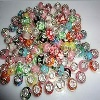

In [335]:
FILE_NAME = f'{DEST_FOLDER}/train/train/B00ALQB3KO.jpg'

bucket = storage_client.get_bucket(BUCKET)
blob = bucket.blob(FILE_NAME)
Image(blob.download_as_bytes(), width=WIDTH, height=HEIGHT)

In [263]:
IMAGE_ID = '097585562X'

cat = train_csv.loc[train_csv['ImgId'] == IMAGE_ID, 'categories'].item()
cat

'Toys & Games'

### Compute Recall

* see official example [here](https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/matching_engine/sdk_matching_engine_for_indexing.ipynb)

In [ ]:
# # Retrieve nearest neighbors for both the tree-AH index and the brute-force index
# tree_ah_response_test = my_index_endpoint.match(
#     deployed_index_id=DEPLOYED_INDEX_ID,
#     queries=list(test),
#     num_neighbors=NUM_NEIGHBOURS,
# )
# brute_force_response_test = my_index_endpoint.match(
#     deployed_index_id=DEPLOYED_BRUTE_FORCE_INDEX_ID,
#     queries=list(test),
#     num_neighbors=NUM_NEIGHBOURS,
# )

In [ ]:
# # Calculate recall by determining how many neighbors were correctly retrieved as compared to the brute-force option.
# recalled_neighbors = 0
# for tree_ah_neighbors, brute_force_neighbors in zip(
#     tree_ah_response_test, brute_force_response_test
# ):
#     tree_ah_neighbor_ids = [neighbor.id for neighbor in tree_ah_neighbors]
#     brute_force_neighbor_ids = [neighbor.id for neighbor in brute_force_neighbors]

#     recalled_neighbors += len(
#         set(tree_ah_neighbor_ids).intersection(brute_force_neighbor_ids)
#     )

# recall = recalled_neighbors / len(
#     [neighbor for neighbors in brute_force_response_test for neighbor in neighbors]
# )

# print("Recall: {}".format(recall))